# Data Preprocessing

In [1]:
%pip install pandas
%pip install matplotlib
%pip install jsonlines

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import json
import jsonlines
import logging
import matplotlib.pyplot as plt
import sys
from functools import reduce
from dataclasses import dataclass

## Data inspection

### Data Source
1. Prometheus Metrics
2. Google Cloud Metrics
3. Locust Metrics (agregated value per minute in `alemira_stats_history.csv`)

Find valuable metrics in Prometheus metrics manually.

In [3]:
class Metric:
    def __init__(self, name: str, data):
        self.metric_name = name
        self.metric_items = []
        if self.check_data(data):
            if type(data) is dict:
                for item in data["result"]:
                    if item["values"]:
                        self.metric_items.append(MetricItem(item))
            elif type(data) is list:
                self.metric_items = data
        self.num_metric_items = len(self.metric_items)

    def check_data(self, data) -> bool:
        if not data:
            logging.warning(f"Empty data in {self.metric_name}!")
            return False
        if type(data) is dict:
            if not data["result"]:
                logging.warning(f"Empty results in {self.metric_name}!")
                return False
            elif data["resultType"] != "matrix":
                logging.warning(f"The format of input data is not supported in {self.metric_name}!")
                return False
            else:
                return True
        elif type(data) is list:
            for item in data:
                if type(item) is not MetricItem:
                    logging.warning(f"The type of {item} is not supported in metric collection!")
                    return False
            return True
        else:
            logging.warning(f"The type of {data} is not supported in metric data!")
            return False
    
    @classmethod
    def init_from_metric_collection(cls, metric_collection: list) -> "Metric":
        if not metric_collection:
            logging.warning("Metric collection is empty!")
            return
        metric_name = metric_collection[0].metric_name
        metric_items = [metric_item for metric in metric_collection for metric_item in metric.metric_items]
        return cls(metric_name, metric_items)

class MetricItem:
    def __init__(self, result_item: dict):
        self.metadata = result_item["metric"]
        self.values = pd.DataFrame(result_item["values"], columns=["timestamp", "value"]).astype({"timestamp": "int64", "value": "float64"})
        self.values["timestamp"] = pd.to_datetime(self.values["timestamp"], unit="s")

    

In [4]:
def get_metric_names(exp_name: str) -> pd.Series:
    metric_names_map_path = os.path.join("metrics", exp_name, "metric_names_map.json")
    return pd.read_json(metric_names_map_path, orient="index", typ="series")
def get_exp_names() -> list:
    return list(filter(lambda f: os.path.isdir(os.path.join("metrics", f)), os.listdir("metrics")))
def get_normal_exp_names() -> list:
    exp_names = get_exp_names()
    return list(filter(lambda exp_name: exp_name.endswith("normal"), exp_names))
def get_metric_index(exp_name: str, metric_name: str):
    metric_names_map_path = os.path.join("metrics", exp_name, "metric_names_map.json")
    with open(metric_names_map_path) as fp:
        metric_names_map = list(json.load(fp).values())
    return metric_names_map.index(metric_name) + 1
def get_metric(exp_name: str, metric_name: str) -> Metric:
    metric_names_map_path = os.path.join("metrics", exp_name, "metric_names_map.json")
    metric_index = get_metric_index(exp_name, metric_name)
    metric_path = os.path.join("metrics", exp_name, f"metric-{metric_index}-day-1.json")
    metric_data = None
    try:
        with open(metric_path) as fp:
            metric_data = json.load(fp)
    except json.JSONDecodeError as e:
        logging.error(f"{metric_name} in {exp_name} cannot be decoded!")
    return Metric(metric_name, metric_data)
def metric_is_too_large(exp_names: list, metric_name: str) -> bool:
    for exp_name in exp_names:
        metric_names_map_path = os.path.join("metrics", exp_name, "metric_names_map.json")
        metric_index = get_metric_index(exp_name, metric_name)
        metric_path = os.path.join("metrics", exp_name, f"metric-{metric_index}-day-1.json")
        filesize = os.path.getsize(metric_path)
        # consider size larger than 50MB as too large
        if filesize / 1024 / 1024 > 50:
            return True
    return False

### Merge metrics
Ignore constant or empty metrics when merging

In [5]:
def merge_valid_prometheus_metrics():
    metrics = [] # contains all metrics' dataframes
    common_metric_names = pd.read_csv(os.path.join("metrics", "common_metrics.csv"))["name"]
    exp_names = get_normal_exp_names()
    num_metric_names = len(common_metric_names)
    for i in range(num_metric_names):
        metric_name = common_metric_names[i]
        print(f"[{i+1}/{num_metric_names}] Processing {metric_name} ...")
        if metric_is_too_large(exp_names, metric_name):
            logging.warning(f"{metric_name} too large!")
            continue
        if metric_name.startswith("apiserver"):
            logging.warning(f"Ignore {metric_name}!")
            continue
        feature_df_list = [] # contains time series data for a submetric/feature
        feature_map = {} # feature name -> metadata
        feature_index = 0
        # combine submetrics into one dataframe
        for exp_name in exp_names:
            metric = get_metric(exp_name, metric_name)
            # if one day's metric is missing then ignore the metric for all days
            if metric.num_metric_items == 0:
                feature_df_list = []
                break
            for item in metric.metric_items:
                feature_index += 1
                feature_df = item.values
                # ignore constant features
                if (feature_df["value"][0] == feature_df["value"]).all():
                    continue
                feature_name = f"{metric.metric_name}_{feature_index}"
                feature_df = feature_df.set_index("timestamp").rename(columns={"value": feature_name})
                feature_df_list.append(feature_df)
                feature_map[feature_name] = item.metadata
        # consider non-empty features
        if feature_df_list:
            combined_df = reduce(lambda item1_df, item2_df: item1_df.join(item2_df, how="outer"), feature_df_list)
            combined_df = combined_df.reset_index()
            combined_df.to_csv(os.path.join("metrics", "combined", f"metric-{i+1}.csv"), index=False)
            with open(os.path.join("metrics", "combined", f"metric-{i+1}-feature-map.json"), 'w') as fp:
                json.dump(feature_map, fp)
            metrics.append(combined_df)
            num_features = len(combined_df.columns)
            print(f"Add metric dataframe with {num_features} valid features")

In [6]:
def write_merged_prometheus_metric_indices():
    combined_path = os.path.join("metrics", "combined")
    indices = [csvfn.lstrip("metrics-").rstrip(".csv") for csvfn in os.listdir(combined_path) if csvfn.endswith(".csv")]
    dest_path = os.path.join("metrics", "merged_prometheus_metric_indices.json")
    with open(dest_path, "w") as fp:
        json.dump(indices, fp)

In [7]:
def check_gcloud_metrics_has_same_metric_type():
    prev_metric_type = None
    folders = [folder for folder in os.listdir("metrics") if folder.startswith("gcloud_metrics")]
    for folder in folders:
        metric_type_map_path = os.path.join("metrics", folder, "metric_type_map.csv")
        metric_type_map = pd.read_csv(metric_type_map_path)
        if prev_metric_type is None:
            prev_metric_type = metric_type_map
        elif not metric_type_map.equals(prev_metric_type):
            print(f"{folder} contains different metric type!")
            return
    print(f"All metrics have the same type.")

In [8]:
def remove_duplicated_gcloud_metric_maps():
    folders = [folder for folder in os.listdir("metrics") if folder.startswith("gcloud_metrics")]
    for folder in folders:
        metric_type_map_path = os.path.join("metrics", folder, "metric_type_map.csv")
        if os.path.exists(metric_type_map_path):
            os.remove(metric_type_map_path)

In [9]:
def gen_unique_kpi_maps(folders: list, metric_type_index: int) -> list:
    """
    Generate a list of unique KPI maps for each metric type in the format of
    {"index": <unique-int>, "gcloud_metrics-day-1": <kpi-index>, "gcloud_metrics-day-2": <kpi-index>, ..., "kpi": {...}}
    """
    unique_kpi_index = 1
    unique_kpi_json_map = dict() # dict of json strings of kpi maps
    for folder in folders:
        kpi_map_path = os.path.join("metrics", folder, f"metric-type-{metric_type_index}", "kpi_map.jsonl")
        with jsonlines.open(kpi_map_path) as reader:
            kpi_map = [obj for obj in reader]
        for kpi_map_item in kpi_map:
            unique_kpi_json = json.dumps(kpi_map_item["kpi"], sort_keys=True)
            if unique_kpi_json in unique_kpi_json_map:
                unique_kpi_json_map[unique_kpi_json][folder] = kpi_map_item["index"]
            else:
                unique_kpi_json_map[unique_kpi_json] = {"index": unique_kpi_index, folder: kpi_map_item["index"], "kpi": kpi_map_item["kpi"]}
                unique_kpi_index += 1
    return list(unique_kpi_json_map.values())

In [10]:
def is_constant_df(df: pd.DataFrame) -> bool:
    return ((df == df.loc[0]).all()).all()

In [11]:
def merge_time_series(unique_kpi_maps: list, metric_type_index: int) -> pd.DataFrame:
    """Merge time series for each metric type and write to a csv file."""
    all_records = []
    for kpi_map in unique_kpi_maps:
        # get folders that share the same KPI
        folders = [key for key in kpi_map if key.startswith("gcloud_metrics-day")]
        combined_kpi = [] # list of dataframes of a single KPI
        for folder in folders:
            kpi_index = kpi_map[folder]
            kpi_path = os.path.join("metrics", folder, f"metric-type-{metric_type_index}", f"kpi-{kpi_index}.csv")
            combined_kpi.append(pd.read_csv(kpi_path))
        # merge time series of the same KPI
        combined_kpi_df = pd.concat(combined_kpi, ignore_index=True)
        if not combined_kpi_df.empty and not is_constant_df(combined_kpi_df.drop(columns="timestamp")):
            kpi_map_index = kpi_map["index"]
            combined_kpi_df = combined_kpi_df.set_index("timestamp").add_prefix(f"kpi-{kpi_map_index}-").reset_index()
            all_records += combined_kpi_df.to_dict("records")
    all_df = pd.DataFrame(all_records)
    all_df = all_df.groupby("timestamp").sum().reset_index()
    return all_df

In [12]:
def metric_type_exists(folders: list, metric_type_index: int) -> bool:
    for folder in folders:
        if not os.path.exists(os.path.join("metrics", folder, f"metric-type-{metric_type_index}")):
            return False
    return True

In [13]:
def merge_valid_gcloud_metrics():
    """Merge non-constant and non-empty gcloud metrics in different days."""
    merge_destination = os.path.join("metrics", "gcloud_combined")
    if not os.path.exists(merge_destination):
        os.mkdir(merge_destination)
    folders = [folder for folder in os.listdir("metrics") if folder.startswith("gcloud_metrics")]
    metric_type_map_path = os.path.join("metrics", "gcloud_metric_type_map.csv")
    metric_type_map = pd.read_csv(metric_type_map_path).set_index("index")
    max_metric_type_index = metric_type_map.index[-1]

    for metric_type_index in metric_type_map.index:
        metric_type = metric_type_map.loc[metric_type_index]
        # check metric type exist
        if not metric_type_exists(folders, metric_type_index):
            continue
        print(f"[{metric_type_index}/{max_metric_type_index}] Processing {metric_type} ...")
        
        # create unique KPI maps
        unique_kpi_maps = gen_unique_kpi_maps(folders, metric_type_index)
        # merge time series 
        merged_df = merge_time_series(unique_kpi_maps, metric_type_index)
        if not merged_df.empty:
            with open(os.path.join(merge_destination, f"metric-{metric_type_index}-kpi-map.json"), "w") as fp:
                json.dump(unique_kpi_maps, fp)
            merged_df.to_csv(os.path.join(merge_destination, f"metric-{metric_type_index}.csv"), index=False)

## Data cleaning

In [14]:
def clean_gcloud_combined():
    """Remove useless KPI map files."""
    kpi_map_files = [f for f in os.listdir(os.path.join("metrics", "gcloud_combined")) if f.endswith("map.json")]
    for kpi_map_file in kpi_map_files:
        metric_type = kpi_map_file.rstrip("-kpi-map.json")
        metric_type_file = f"{metric_type}.csv"
        metric_type_path = os.path.join("metrics", "gcloud_combined", metric_type_file)
        kpi_map_path = os.path.join("metrics", "gcloud_combined", kpi_map_file)
        # remove useless KPI maps
        if not os.path.exists(metric_type_path):
            os.remove(kpi_map_path)
        # remove useless keys
        with open(kpi_map_path) as fp:
            kpi_maps = json.load(fp)
        for kpi_map in kpi_maps:
            useless_keys = [key for key in kpi_map if key.startswith("gcloud_metrics-day")]
            for key in useless_keys:
                kpi_map.pop(key)
        with open(kpi_map_path, "w") as fp:
            json.dump(kpi_maps, fp)

In [15]:
def clean_prom_metrics(func):
    """
    Clean prometheus with the provided function.

    Parameters
    ----------
    func : Callable
        a callable function accepts 4 arguments (metric_index, metric_name, metric_feature_map_path, metric_path) to clean data
    """
    common_metric_names = pd.read_csv(os.path.join("metrics", "common_metrics.csv"))["name"]
    for i in range(len(common_metric_names)):
        metric_index = i + 1
        metric_name = common_metric_names[i]
        metric_feature_map_path = os.path.join("metrics", "combined", f"metric-{metric_index}-feature-map.json")
        metric_path = os.path.join("metrics", "combined", f"metric-{metric_index}.csv")
        if not os.path.exists(metric_feature_map_path) and not os.path.exists(metric_path):
            continue
        print(f"Processing metric {metric_index} {metric_name} ...")
        func(metric_index, metric_name, metric_feature_map_path, metric_path)

### Remove unrelated metrics
1. apiserver metrics
2. namespace is not *alms*

In [16]:
def remove_unrelated_metrics(metric_index: int, metric_name: str, metric_feature_map_path: str, metric_path: str):
    # simply ignore apiserver metrics
    if metric_name.startswith("apiserver"):
        print(f"delete metric {metric_index} {metric_name}")
        os.remove(metric_feature_map_path)
        os.remove(metric_path)
    # ignore metrics with namespace not alms
    else:
        unrelated_features = []
        with open(metric_feature_map_path) as fp:
            metric_feature_map = json.load(fp)
        if metric_feature_map:
            for feature_key, feature_value in metric_feature_map.items():
                if "namespace" in feature_value and feature_value["namespace"] != "alms":
                    unrelated_features.append(feature_key)
        else:
            print(f"delete metric {metric_index} {metric_name}")
            os.remove(metric_feature_map_path)
            os.remove(metric_path)
        if unrelated_features:
            for feature in unrelated_features:
                metric_feature_map.pop(feature)
            if metric_feature_map:
                with open(metric_feature_map_path, "w") as fp:
                    json.dump(metric_feature_map, fp)
                df_metric = pd.read_csv(metric_path)
                if df_metric.empty:
                    print(f"delete metric {metric_index} {metric_name}")
                    os.remove(metric_feature_map_path)
                    os.remove(metric_path)
                df_metric = df_metric.drop(columns=unrelated_features)
                df_metric.to_csv(metric_path, index=False)
            else:
                print(f"delete metric {metric_index} {metric_name}")
                os.remove(metric_feature_map_path)
                os.remove(metric_path)

### Make timestamp consistent
Currently, timestamps have granularity of one second, which makes it difficult to combine different metrics with granularity of one minute.

Make timestemps as first second of its closest minute, e.g. 16:38:41 -> 16:39:00, 17:27:12 -> 17:27:00

Simply aggregate by `(month, day, hour, minute)` with pandas's `Timestamp` object

## Data aggregation

aggregate data with same containers, services, etc. but different pods (frequently changeable)

min, max, mean, median, std, sum, quantile (.5, .75, .8, .9, .99)

### Aggregate GCloud time series

Separate into 3 categories:
1. aggregate on `container_name`

pod_name
node_name


In [23]:
@dataclass
class GCloudAgg:
    NUM_KPI_MAPS_THRESHOLD = 16 # based on metric type 1
    GCLOUD_COMBINED_PATH = os.path.join("metrics", "gcloud_combined")
    AGG_OUTPUT_PATH = os.path.join("metrics", "gcloud_aggregated")
    @staticmethod
    def get_metric_indices() -> list:
        return [filename.lstrip("metric-").rstrip("-kpi-map.json") for filename in os.listdir(GCloudAgg.GCLOUD_COMBINED_PATH) if filename.endswith("kpi-map.json")]
    @staticmethod
    def get_df_kpi_map(metric_index: int) -> pd.DataFrame:
        kpi_map_path = os.path.join(GCloudAgg.GCLOUD_COMBINED_PATH, f"metric-{metric_index}-kpi-map.json")
        with open(kpi_map_path) as fp:
            kpi_map_list = json.load(fp)
        kpi_maps = [kpi_map["kpi"] for kpi_map in kpi_map_list]
        indices = [kpi_map["index"] for kpi_map in kpi_map_list]
        df_kpi_map = pd.DataFrame(kpi_maps, index=indices)
        return df_kpi_map
    @staticmethod
    def get_df_metric(metric_index: int) -> pd.DataFrame:
        metric_path = os.path.join(GCloudAgg.GCLOUD_COMBINED_PATH, f"metric-{metric_index}.csv")
        return pd.read_csv(metric_path)
    @staticmethod
    def index_list(series) -> list:
        return series.to_list()
    @staticmethod
    def is_distribution(cols: list) -> bool:
        for col in cols:
            if "count" in col or "mean" in col or "sum_of_squared_deviation" in col:
                return True
        return False
    @staticmethod
    def aggregate_with_container_name(metric_index: int, df_kpi_map: pd.DataFrame):
        """Aggregate KPIs with same container name."""
        print(f"Aggregating metric {metric_index} with same container name ...")
        # remove labels with same values
        isunique = df_kpi_map.nunique() == 1
        df_kpi_map_unique = df_kpi_map.drop(columns=isunique.index[isunique])
        # aggregate all columns except pod_name
        df_kpi_map_unique.drop(columns="pod_name", inplace=True)
        group_columns = df_kpi_map_unique.columns.to_list()
        df_kpi_map_unique = df_kpi_map_unique.reset_index().groupby(group_columns).agg(GCloudAgg.index_list)
        GCloudAgg.aggregate(metric_index, df_kpi_map_unique)
        
    @staticmethod
    def aggregate_with_all_kpis(metric_index: int, df_kpi_map: pd.DataFrame):
        """Aggregate KPIs with only different node names."""
        print(f"Aggregating metric {metric_index} with all KPIs ...")
        isunique = df_kpi_map.nunique() == 1
        df_same = df_kpi_map[isunique.index[isunique]]
        group_columns = df_same.columns.to_list()
        df_same = df_same.reset_index().groupby(group_columns).agg(GCloudAgg.index_list)
        GCloudAgg.aggregate(metric_index, df_same)
        

    @staticmethod
    def aggregate_with_pod_service(metric_index: int, df_kpi_map: pd.DataFrame):
        """Aggregate KPIs with same pod service extracted from the pod name."""
        print(f"Aggregating metric {metric_index} with same pod service ...")
        # remove labels with same values
        isunique = df_kpi_map.nunique() == 1
        df_kpi_map_unique = df_kpi_map.drop(columns=isunique.index[isunique])
        df_kpi_map_unique["pod_name"] = df_kpi_map_unique["pod_name"].str.extract(r'(alms[-a-z]+)-')
        df_kpi_map_unique.drop(columns=[col for col in df_kpi_map_unique.columns if col not in ["pod_name", "remote_network"]], inplace=True)
        group_columns = ["pod_name"]
        if "remote_network" in df_kpi_map:
            group_columns.append("remote_network")
        df_kpi_map_unique = df_kpi_map_unique.reset_index().groupby(group_columns).agg(GCloudAgg.index_list)
        GCloudAgg.aggregate(metric_index, df_kpi_map_unique)

    @staticmethod
    def aggregate_with_selected_labels(metric_index: int, df_kpi_map: pd.DataFrame):
        """Aggregate KPIs with selected labels."""
        print(f"Aggregating metric {metric_index} with selected labels ...")
        group_columns = df_kpi_map.columns.to_list()
        df_kpi_map_unique = df_kpi_map.reset_index().groupby(group_columns).agg(GCloudAgg.index_list)
        GCloudAgg.aggregate(metric_index, df_kpi_map_unique)
        
    @staticmethod
    def adapt_no_agg(metric_index: int, df_kpi_map: pd.DataFrame):
        """Adapt metrics no need for aggregation."""
        print(f"Adapting metric {metric_index} without aggregation ...")
        df_metric = GCloudAgg.get_df_metric(metric_index).set_index("timestamp")
        new_kpi_map_list = []
        new_kpi_map_index = 1
        for i in df_kpi_map.index:
            original_column_name = f"kpi-{i}-value"
            if original_column_name in df_metric.columns:
                # adapt KPI map
                kpi_keys = df_kpi_map.columns
                kpi_values = df_kpi_map.loc[i]
                kpi = {kpi_keys[i]: kpi_values[i] for i in range(len(kpi_keys))}
                new_kpi_map = {"index": new_kpi_map_index, "kpi": kpi}
                new_kpi_map_list.append(new_kpi_map)
                # adapt metric
                df_metric.rename(columns={original_column_name: f"agg-kpi-{new_kpi_map_index}"}, inplace=True)
                new_kpi_map_index += 1
        with open(os.path.join(GCloudAgg.AGG_OUTPUT_PATH, f"metric-{metric_index}-kpi-map.json"), "w") as fp:
            json.dump(new_kpi_map_list, fp)
        df_metric.to_csv(os.path.join(GCloudAgg.AGG_OUTPUT_PATH, f"metric-{metric_index}.csv"))

    @staticmethod
    def gen_df_metric_agg(df_metric_to_agg: pd.DataFrame) -> pd.DataFrame:
        min_series = df_metric_to_agg.min(axis=1).rename("min")
        max_series = df_metric_to_agg.max(axis=1).rename("max")
        mean_series = df_metric_to_agg.mean(axis=1).rename("mean")
        median_series = df_metric_to_agg.median(axis=1).rename("median")
        std_series = df_metric_to_agg.std(axis=1).rename("std")
        sum_series = df_metric_to_agg.sum(axis=1).rename("sum")
        quantile_series = df_metric_to_agg.quantile([.5, .75, .8, .9, .99], axis=1).transpose()
        df_metric_agg = pd.concat([min_series, max_series, mean_series, median_series, std_series, sum_series, quantile_series], axis=1)
        return df_metric_agg

    @staticmethod
    def aggregate_normal(df_kpi_map_unique: pd.DataFrame, df_metric: pd.DataFrame, metric_index: int):
        new_kpi_map_list = []
        new_kpi_map_index = 1
        df_agg_list = []
        for row in df_kpi_map_unique.itertuples():
            # generate new KPI
            kpi_keys = df_kpi_map_unique.index.names
            kpi_values = row[0]
            kpi = {kpi_keys[i]: kpi_values[i] for i in range(len(kpi_keys))}
            new_kpi_map = {"index": new_kpi_map_index, "kpi": kpi}

            indices_with_metrics = [int(column.lstrip("kpi-").rstrip("-value")) for column in df_metric.columns.to_list()]
            valid_indices = list(set(row[1]) & set(indices_with_metrics))
            columns_to_merge = [f"kpi-{i}-value" for i in valid_indices]

            if len(columns_to_merge) == 1:
                new_kpi_map_list.append(new_kpi_map)
                single_column_name = columns_to_merge[0]
                df_agg_list.append(df_metric[single_column_name].rename(f"agg-kpi-{new_kpi_map_index}"))
                new_kpi_map_index += 1
                continue
            elif len(columns_to_merge) == 0:
                continue
            new_kpi_map_list.append(new_kpi_map)
            # merge more than 1 columns
            df_metric_to_agg = df_metric[columns_to_merge]
            df_metric_agg = GCloudAgg.gen_df_metric_agg(df_metric_to_agg).add_prefix(f"agg-kpi-{new_kpi_map_index}-")
            df_agg_list.append(df_metric_agg)
            new_kpi_map_index += 1
        df_complete_agg = pd.concat(df_agg_list, axis=1)
        if not df_complete_agg.empty:
            with open(os.path.join(GCloudAgg.AGG_OUTPUT_PATH, f"metric-{metric_index}-kpi-map.json"), "w") as fp:
                json.dump(new_kpi_map_list, fp)
            df_complete_agg.to_csv(os.path.join(GCloudAgg.AGG_OUTPUT_PATH, f"metric-{metric_index}.csv"))
        
    @staticmethod
    def aggregate_distribution(df_kpi_map_unique: pd.DataFrame, df_metric: pd.DataFrame, metric_index: int):
        new_kpi_map_list = []
        new_kpi_map_index = 1
        df_agg_list = []
        for row in df_kpi_map_unique.itertuples():
            # generate new KPI
            kpi_keys = df_kpi_map_unique.index.names
            kpi_values = row[0]
            kpi = {kpi_keys[i]: kpi_values[i] for i in range(len(kpi_keys))}
            new_kpi_map = {"index": new_kpi_map_index, "kpi": kpi}

            indices_with_metrics = [int(column.split("-")[1]) for column in df_metric.columns.to_list()]
            valid_indices = list(set(row[1]) & set(indices_with_metrics))
            columns_count_to_merge = [f"kpi-{i}-count" for i in valid_indices]
            columns_mean_to_merge = [f"kpi-{i}-mean" for i in valid_indices]
            columns_sd_to_merge = [f"kpi-{i}-sum_of_squared_deviation" for i in valid_indices]

            if len(columns_count_to_merge) == 1:
                new_kpi_map_list.append(new_kpi_map)
                single_column_name = [columns_count_to_merge[0], columns_mean_to_merge[0], columns_sd_to_merge[0]]
                df_agg_list.append(df_metric[single_column_name].rename(columns={
                    columns_count_to_merge[0]: f"agg-kpi-{new_kpi_map_index}-count", 
                    columns_mean_to_merge[0]: f"agg-kpi-{new_kpi_map_index}-mean",
                    columns_sd_to_merge[0]: f"agg-kpi-{new_kpi_map_index}-sd"}))
                new_kpi_map_index += 1
                continue
            elif len(columns_count_to_merge) == 0:
                continue
            new_kpi_map_list.append(new_kpi_map)
            # merge more than 1 columns
            df_metric_count_to_agg = df_metric[columns_count_to_merge]
            df_metric_count_agg = GCloudAgg.gen_df_metric_agg(df_metric_count_to_agg).add_prefix(f"agg-kpi-{new_kpi_map_index}-").add_suffix("-count")
            df_agg_list.append(df_metric_count_agg)
            df_metric_mean_to_agg = df_metric[columns_mean_to_merge]
            df_metric_mean_agg = GCloudAgg.gen_df_metric_agg(df_metric_mean_to_agg).add_prefix(f"agg-kpi-{new_kpi_map_index}-").add_suffix("-mean")
            df_agg_list.append(df_metric_mean_agg)
            df_metric_sd_to_agg = df_metric[columns_sd_to_merge]
            df_metric_sd_agg = GCloudAgg.gen_df_metric_agg(df_metric_sd_to_agg).add_prefix(f"agg-kpi-{new_kpi_map_index}-").add_suffix("-sd")
            df_agg_list.append(df_metric_sd_agg)
            new_kpi_map_index += 1
        df_complete_agg = pd.concat(df_agg_list, axis=1)
        if not df_complete_agg.empty:
            with open(os.path.join(GCloudAgg.AGG_OUTPUT_PATH, f"metric-{metric_index}-kpi-map.json"), "w") as fp:
                json.dump(new_kpi_map_list, fp)
            df_complete_agg.to_csv(os.path.join(GCloudAgg.AGG_OUTPUT_PATH, f"metric-{metric_index}.csv"))
    @staticmethod
    def aggregate(metric_index: int, df_kpi_map_unique: pd.DataFrame):
        df_metric = GCloudAgg.get_df_metric(metric_index).set_index("timestamp")
        if GCloudAgg.is_distribution(df_metric.columns):
            GCloudAgg.aggregate_distribution(df_kpi_map_unique, df_metric, metric_index)
        else:
            GCloudAgg.aggregate_normal(df_kpi_map_unique, df_metric, metric_index)

    @staticmethod
    def perform_aggregation_for_all_metrics():
        if not os.path.exists(GCloudAgg.AGG_OUTPUT_PATH):
            os.mkdir(GCloudAgg.AGG_OUTPUT_PATH)
        for i in GCloudAgg.get_metric_indices():
            df_kpi_map = GCloudAgg.get_df_kpi_map(i)
            if len(df_kpi_map) > GCloudAgg.NUM_KPI_MAPS_THRESHOLD:
                if "pod_name" in df_kpi_map:
                    if "container_name" in df_kpi_map:
                        GCloudAgg.aggregate_with_container_name(i, df_kpi_map)
                    else:
                        GCloudAgg.aggregate_with_pod_service(i, df_kpi_map)
                else:
                    # ignore columns with only single one unique value
                    isunique = df_kpi_map.nunique() == 1
                    df_kpi_map_unique = df_kpi_map.drop(columns=isunique.index[isunique])
                    # ignore columns with more than 20 unique values
                    isunique = df_kpi_map_unique.nunique() > 20
                    df_kpi_map_unique = df_kpi_map_unique.drop(columns=isunique.index[isunique])
                    if len(df_kpi_map_unique.columns) <= 1:
                        GCloudAgg.aggregate_with_all_kpis(i, df_kpi_map)
                    else:
                        GCloudAgg.aggregate_with_selected_labels(i, df_kpi_map_unique)
            else:
                GCloudAgg.adapt_no_agg(i, df_kpi_map)


In [18]:
# for i in GCloudAgg.get_metric_indices():
#     df_kpi_map = GCloudAgg.get_df_kpi_map(i)
#     if len(df_kpi_map) > GCloudAgg.NUM_KPI_MAPS_THRESHOLD:
#         if "container_name" in df_kpi_map and "pod_name" in df_kpi_map:
#             GCloudAgg.aggregate_with_container_name(i, df_kpi_map)
#     else:
#         print("handle no aggregation, move to agg folder")

In [19]:
# for i in GCloudAgg.get_metric_indices():
#     df_kpi_map = GCloudAgg.get_df_kpi_map(i)
#     if len(df_kpi_map) > GCloudAgg.NUM_KPI_MAPS_THRESHOLD:
#         if "container_name" not in df_kpi_map and "pod_name" in df_kpi_map:
#             GCloudAgg.aggregate_with_pod_service(i, df_kpi_map)

In [20]:
# for i in GCloudAgg.get_metric_indices():
#     df_kpi_map = GCloudAgg.get_df_kpi_map(i)
#     if len(df_kpi_map) > GCloudAgg.NUM_KPI_MAPS_THRESHOLD:
#         if "pod_name" not in df_kpi_map:
#             # ignore columns with only single one unique value
#             isunique = df_kpi_map.nunique() == 1
#             df_kpi_map_unique = df_kpi_map.drop(columns=isunique.index[isunique])
#             # ignore columns with more than 20 unique values
#             isunique = df_kpi_map_unique.nunique() > 20
#             df_kpi_map_unique = df_kpi_map_unique.drop(columns=isunique.index[isunique])
#             if len(df_kpi_map_unique.columns) <= 1:
#                 GCloudAgg.aggregate_with_all_kpis(i, df_kpi_map)

In [21]:
# if not os.path.exists(GCloudAgg.AGG_OUTPUT_PATH):
#     os.mkdir(GCloudAgg.AGG_OUTPUT_PATH)
# for i in GCloudAgg.get_metric_indices():
#     df_kpi_map = GCloudAgg.get_df_kpi_map(i)
#     if len(df_kpi_map) > GCloudAgg.NUM_KPI_MAPS_THRESHOLD:
#         if "pod_name" not in df_kpi_map:
#             # ignore columns with only single one unique value
#             isunique = df_kpi_map.nunique() == 1
#             df_kpi_map_unique = df_kpi_map.drop(columns=isunique.index[isunique])
#             # ignore columns with more than 20 unique values
#             isunique = df_kpi_map_unique.nunique() > 20
#             df_kpi_map_unique = df_kpi_map_unique.drop(columns=isunique.index[isunique])
#             if len(df_kpi_map_unique.columns) > 1:
#                 GCloudAgg.aggregate_with_selected_labels(i, df_kpi_map_unique)

In [24]:
# for i in GCloudAgg.get_metric_indices():
#     df_kpi_map = GCloudAgg.get_df_kpi_map(i)
#     if len(df_kpi_map) <= GCloudAgg.NUM_KPI_MAPS_THRESHOLD:
#         GCloudAgg.adapt_no_agg(i, df_kpi_map)

Adapting metric 2 without aggregation ...
Adapting metric 1 without aggregation ...
Adapting metric 65 without aggregation ...


In [25]:
len(os.listdir(os.path.join("metrics", "gcloud_combined"))) == len(os.listdir(os.path.join("metrics", "gcloud_aggregated")))

True

In [37]:
df_kpi_map

,subnetwork_id,subnetwork_name,location,project_id,resource_type
1,6125695369636969066,default,europe-west6,peerless-column-365315,gce_subnetwork
2,UNKNOWN,,global,peerless-column-365315,gce_subnetwork


In [33]:
for i in df_kpi_map.index:
    kpi_keys = df_kpi_map.columns
    kpi_values = df_kpi_map.loc[i]
    kpi = {kpi_keys[i]: kpi_values[i] for i in range(len(kpi_keys))}
    new_kpi_map = {"index": i, "kpi": kpi}
    print(new_kpi_map)

{'index': 1, 'kpi': {'subnetwork_id': '6125695369636969066', 'subnetwork_name': 'default', 'location': 'europe-west6', 'project_id': 'peerless-column-365315', 'resource_type': 'gce_subnetwork'}}
{'index': 2, 'kpi': {'subnetwork_id': 'UNKNOWN', 'subnetwork_name': '', 'location': 'global', 'project_id': 'peerless-column-365315', 'resource_type': 'gce_subnetwork'}}


In [23]:
metric_index = 45
df_metric = GCloudAgg.get_df_metric(metric_index).set_index("timestamp")
df = GCloudAgg.get_df_kpi_map(metric_index)
isunique = df.nunique() == 1
df_kpi_map_unique = df.drop(columns=isunique.index[isunique])
isunique = df_kpi_map_unique.nunique() > 20
df_kpi_map_unique = df_kpi_map_unique.drop(columns=isunique.index[isunique])
df_kpi_map_unique

,memory_type,component
1,evictable,docker-daemon
2,non-evictable,docker-daemon
3,evictable,kubelet
4,non-evictable,kubelet
5,evictable,pods
...,...,...
482,non-evictable,docker-daemon
483,evictable,kubelet
484,non-evictable,kubelet
485,evictable,pods


In [24]:
group_columns = df_kpi_map_unique.columns.to_list()
df = df_kpi_map_unique.reset_index().groupby(group_columns).agg(GCloudAgg.index_list)
df

index
memory_type   component                                                       
evictable     docker-daemon  [1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67,...
              kubelet        [3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69,...
              pods           [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71...
non-evictable docker-daemon  [2, 8, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68,...
              kubelet        [4, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, 70...
              pods           [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72...

In [35]:
df

,project_id,instance_id,zone,local_subnetwork,remote_country,protocol,remote_subnetwork,remote_vpn_tunnel,remote_network,network_topology_remote_label,local_network_interface,remote_region,local_network,remote_location_type,remote_continent,remote_zone,remote_project_id,resource_type
1,peerless-column-365315,1054550057825510950,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
2,peerless-column-365315,1830815364503156666,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
3,peerless-column-365315,1983079656022725746,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
4,peerless-column-365315,233112514216199965,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
5,peerless-column-365315,2683926990545278806,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,peerless-column-365315,474709230683787569,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
124,peerless-column-365315,7259576094465054678,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
125,peerless-column-365315,8539033198242402713,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance
126,peerless-column-365315,9050896903679628514,europe-west6-a,default,NOT_APPLICABLE,TCP,default,UNSUPPORTED,default,UNSUPPORTED,nic0,europe-west6,default,CLOUD,NOT_APPLICABLE,europe-west6-a,peerless-column-365315,gce_instance


In [34]:
"kpi-1-count".split("-")[1]

['kpi', '1', 'count']

In [114]:
test_indices = df_unique["index"][1]
indices_with_metrics = [int(column.lstrip("kpi-").rstrip("-value")) for column in df_metric.columns.to_list()]
valid_indices = list(set(test_indices) & set(indices_with_metrics))
columns_to_merge = [f"kpi-{i}-value" for i in valid_indices]
df_metric_to_agg = df_metric[columns_to_merge]
df_metric_to_agg

,kpi-2-value,kpi-899-value,kpi-4-value,kpi-6-value,kpi-1931-value,kpi-1933-value,kpi-270-value,kpi-1935-value,kpi-272-value,kpi-274-value,...,kpi-2766-value,kpi-2768-value,kpi-484-value,kpi-486-value,kpi-488-value,kpi-1262-value,kpi-1264-value,kpi-1266-value,kpi-2173-value,kpi-2175-value
timestamp,,,,,,,,,,,,,,,,,,,,,
1680008100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680008160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680008220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680008280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680008340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681415760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.490234,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681415820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.490234,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681415880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.490234,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
min_series = df_metric_to_agg.min(axis=1).rename("min")
max_series = df_metric_to_agg.max(axis=1).rename("max")
mean_series = df_metric_to_agg.mean(axis=1).rename("mean")
median_series = df_metric_to_agg.median(axis=1).rename("median")
std_series = df_metric_to_agg.std(axis=1).rename("std")
sum_series = df_metric_to_agg.sum(axis=1).rename("sum")
quantile_series = df_metric_to_agg.quantile([.5, .75, .8, .9, .99], axis=1).transpose()
df_metric_agg = pd.concat([min_series, max_series, mean_series, median_series, std_series, sum_series, quantile_series], axis=1)
df_metric_agg

,min,max,mean,median,std,sum,0.5,0.75,0.8,0.9,0.99
timestamp,,,,,,,,,,,
1680008100,0.0,0.489258,0.016871,0.0,0.090853,0.489258,0.0,0.0,0.0,0.0,0.352266
1680008160,0.0,0.496094,0.017107,0.0,0.092122,0.496094,0.0,0.0,0.0,0.0,0.357187
1680008220,0.0,0.496094,0.017107,0.0,0.092122,0.496094,0.0,0.0,0.0,0.0,0.357187
1680008280,0.0,0.496094,0.017107,0.0,0.092122,0.496094,0.0,0.0,0.0,0.0,0.357187
1680008340,0.0,0.496094,0.017107,0.0,0.092122,0.496094,0.0,0.0,0.0,0.0,0.357187
...,...,...,...,...,...,...,...,...,...,...,...
1681415760,0.0,0.490234,0.016905,0.0,0.091034,0.490234,0.0,0.0,0.0,0.0,0.352969
1681415820,0.0,0.490234,0.016905,0.0,0.091034,0.490234,0.0,0.0,0.0,0.0,0.352969
1681415880,0.0,0.490234,0.016905,0.0,0.091034,0.490234,0.0,0.0,0.0,0.0,0.352969


In [111]:
pd.concat([min_series,quantile_series],axis=1)

,min,0.5,0.75,0.8,0.9,0.99
timestamp,,,,,,
1680008100,0.0,0.0,0.0,0.0,0.0,0.352266
1680008160,0.0,0.0,0.0,0.0,0.0,0.357188
1680008220,0.0,0.0,0.0,0.0,0.0,0.357188
1680008280,0.0,0.0,0.0,0.0,0.0,0.357188
1680008340,0.0,0.0,0.0,0.0,0.0,0.357188
...,...,...,...,...,...,...
1681415760,0.0,0.0,0.0,0.0,0.0,0.352969
1681415820,0.0,0.0,0.0,0.0,0.0,0.352969
1681415880,0.0,0.0,0.0,0.0,0.0,0.352969


In [71]:
for row in df_unique[:5].itertuples():
    columns_to_merge = [f"kpi-{i}-value" for i in row[1]]
    print(columns_to_merge)

['kpi-1-value', 'kpi-3-value', 'kpi-5-value', 'kpi-269-value', 'kpi-271-value', 'kpi-273-value', 'kpi-483-value', 'kpi-485-value', 'kpi-487-value', 'kpi-898-value', 'kpi-1261-value', 'kpi-1263-value', 'kpi-1265-value', 'kpi-1555-value', 'kpi-1557-value', 'kpi-1930-value', 'kpi-1932-value', 'kpi-1934-value', 'kpi-2078-value', 'kpi-2080-value', 'kpi-2172-value', 'kpi-2174-value', 'kpi-2579-value', 'kpi-2765-value', 'kpi-2767-value', 'kpi-2876-value', 'kpi-2974-value', 'kpi-2976-value', 'kpi-3227-value']
['kpi-2-value', 'kpi-4-value', 'kpi-6-value', 'kpi-270-value', 'kpi-272-value', 'kpi-274-value', 'kpi-484-value', 'kpi-486-value', 'kpi-488-value', 'kpi-899-value', 'kpi-1262-value', 'kpi-1264-value', 'kpi-1266-value', 'kpi-1556-value', 'kpi-1558-value', 'kpi-1931-value', 'kpi-1933-value', 'kpi-1935-value', 'kpi-2079-value', 'kpi-2081-value', 'kpi-2173-value', 'kpi-2175-value', 'kpi-2580-value', 'kpi-2766-value', 'kpi-2768-value', 'kpi-2877-value', 'kpi-2975-value', 'kpi-2977-value', 'kpi

### Data Shape
rows x columns

each column represents a KPI

*Prometheus time series*: 20,160 x 1,792,225 -> 20,160 x 67,561

*GCloud time series*: 20,160 x 87,274 -> 20,160 x 68,722

*Locust time series*: 20,160 x 23 -> 20,160 x 21

~ 20,000

In [6]:
# def check_gcloud_shape():
metric_path = os.path.join("metrics", "gcloud_combined")
kpi_map_filenames = [filename for filename in os.listdir(metric_path) if filename.endswith("kpi-map.json")]
num_column = 0
for kpi_map_filename in kpi_map_filenames:
    with open(os.path.join(metric_path, kpi_map_filename)) as fp:
        kpi_map = json.load(fp)
    num_column += len(kpi_map)
num_column

68722

In [14]:
num_column = 0
common_metric_names = pd.read_csv(os.path.join("metrics", "common_metrics.csv"))["name"]
for i in range(len(common_metric_names)):
    metric_index = i + 1
    metric_feature_map_path = os.path.join("metrics", "combined", f"metric-{metric_index}-feature-map.json")
    if os.path.exists(metric_feature_map_path):
        with open(metric_feature_map_path) as fp:
            metric_feature_map = json.load(fp)
            num_column += len(metric_feature_map)
num_column

67561

In [57]:
combined_df.empty

True

In [5]:
metric_dir = os.path.join("metrics", DAY_1_NORMAL)
metric_names = get_metric_names(DAY_1_NORMAL)
metric_names

1               :node_memory_MemAvailable_bytes:sum
2                                            ALERTS
3                                  ALERTS_FOR_STATE
4          aggregator_openapi_v2_regeneration_count
5       aggregator_openapi_v2_regeneration_duration
                           ...                     
1201                        workqueue_retries_total
1202              workqueue_unfinished_work_seconds
1203         workqueue_work_duration_seconds_bucket
1204          workqueue_work_duration_seconds_count
1205            workqueue_work_duration_seconds_sum
Length: 1205, dtype: object

In [ ]:
# data names
DAY_1_LINEAR_CPU_IDENTITY = "day-1-linear-cpu-identity"
DAY_1_LINEAR_MEMORY_IDENTITY = "day-1-linear-memory-identity"
DAY_1_NORMAL = "day-1-normal"

In [7]:
# constant: 3, inconstant: 660
example_metric_name_index = 860
example_metric_path = os.path.join(metric_dir, f"metric-{example_metric_name_index}-day-1.json")
with open(example_metric_path) as fp:
    data = json.load(fp)
example_metric = Metric(metric_names[example_metric_name_index], data)
example_metadata = [item.metadata for item in example_metric.metric_items]
df_example_metadata = pd.DataFrame(example_metadata)
df_example_metadata

,__name__,container,endpoint,instance,job,namespace,pod,service
0,node_procs_running,node-exporter,http-metrics,10.172.0.36:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-6ph64,prometheus-prometheus-node-exporter
1,node_procs_running,node-exporter,http-metrics,10.172.0.43:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-vqjsv,prometheus-prometheus-node-exporter
2,node_procs_running,node-exporter,http-metrics,10.172.0.50:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-gwchq,prometheus-prometheus-node-exporter
3,node_procs_running,node-exporter,http-metrics,10.172.0.52:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-lf5dx,prometheus-prometheus-node-exporter
4,node_procs_running,node-exporter,http-metrics,10.172.0.54:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-4dsmv,prometheus-prometheus-node-exporter
5,node_procs_running,node-exporter,http-metrics,10.172.0.54:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-6bsnl,prometheus-prometheus-node-exporter
6,node_procs_running,node-exporter,http-metrics,10.172.0.55:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-p5w9b,prometheus-prometheus-node-exporter
7,node_procs_running,node-exporter,http-metrics,10.172.0.56:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-rzqvn,prometheus-prometheus-node-exporter
8,node_procs_running,node-exporter,http-metrics,10.172.0.57:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-6tclh,prometheus-prometheus-node-exporter
9,node_procs_running,node-exporter,http-metrics,10.172.0.58:9100,node-exporter,prometheus,prometheus-prometheus-node-exporter-9j78h,prometheus-prometheus-node-exporter


200 0000 -> 500

TODO: Remove all sub-metrics with 0s or constants

KPIs

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13
timestamp,,,,,,,,,,,,,
2023-03-28 13:54:05,NaN,NaN,1.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-28 13:55:05,NaN,NaN,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-28 13:56:05,NaN,NaN,6.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-28 13:57:05,NaN,NaN,1.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-28 13:58:05,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 13:49:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,2.0,NaN,NaN
2023-03-29 13:50:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,2.0,NaN,NaN
2023-03-29 13:51:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,2.0,NaN,NaN


assume NaN as 0

{'__name__': 'node_procs_running', 'container': 'node-exporter', 'endpoint': 'http-metrics', 'instance': '10.172.0.43:9100', 'job': 'node-exporter', 'namespace': 'prometheus', 'pod': 'prometheus-prometheus-node-exporter-vqjsv', 'service': 'prometheus-prometheus-node-exporter'}


,timestamp,value
0,2023-03-29 04:11:05,1.0
1,2023-03-29 04:12:05,1.0
2,2023-03-29 04:13:05,1.0
3,2023-03-29 04:14:05,1.0
4,2023-03-29 04:15:05,1.0
5,2023-03-29 04:16:05,1.0
6,2023-03-29 04:17:05,1.0
7,2023-03-29 04:18:05,2.0
8,2023-03-29 04:19:05,1.0
9,2023-03-29 04:20:05,1.0


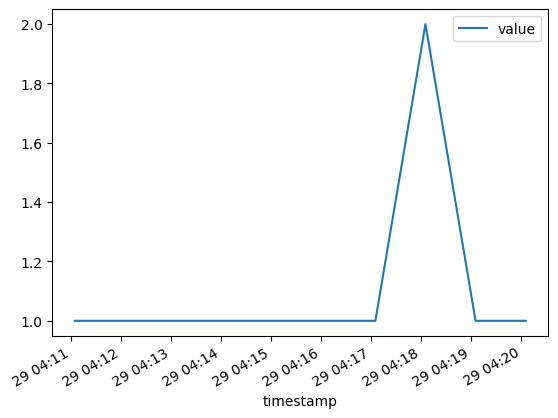

In [9]:
example_metric_item = example_metric.metric_items[1]
print(example_metric_item.metadata)
example_metric_item.values.plot(x="timestamp", y="value")
example_metric_item.values

In [10]:
example_metric_item2_df = example_metric.metric_items[0].values.set_index("timestamp").rename(columns={"value": "value2"})
example_metric_item1_df = example_metric_item.values.set_index("timestamp").rename(columns={"value": "value1"})
example_metric_item1_df.join(example_metric_item2_df)

,value1,value2
timestamp,,
2023-03-29 04:11:05,1.0,NaN
2023-03-29 04:12:05,1.0,NaN
2023-03-29 04:13:05,1.0,NaN
2023-03-29 04:14:05,1.0,NaN
2023-03-29 04:15:05,1.0,NaN
2023-03-29 04:16:05,1.0,NaN
2023-03-29 04:17:05,1.0,NaN
2023-03-29 04:18:05,2.0,NaN
2023-03-29 04:19:05,1.0,NaN


## Extract common metrics

In [18]:
def extract_common_metrics_names():
    """Extracts common metrics names from all experiments and outputs to a file named as common_metrics.csv"""
    names = []
    for exp_name in get_exp_names():
        metric_names_map_path = os.path.join("metrics", exp_name, "metric_names_map.json")
        with open(metric_names_map_path) as fp:
            names.append(set(json.load(fp).values()))
    first_name = names[0]
    rest_names = names[1:]
    df = pd.DataFrame(first_name.intersection(*rest_names), columns=["name"])
    df.to_csv("metrics/common_metrics.csv", index=False)
extract_common_metrics_names()

## Find constant and empty metrics

In [ ]:
def find_constant_metrics(metric_names: list[str], metric_dir: str) -> list:
    constant_metrics = []
    num_metric_names = len(metric_names)
    for i in metric_names.index:
        print(f"[{i}/{num_metric_names}] Processing {metric_names[i]} ...")
        metric_path = os.path.join(metric_dir, f"metric-{i}-day-1.json")
        with open(metric_path) as fp:
            data = json.load(fp)
        metric = Metric(metric_names[i], data)
        is_constant = [False] * metric.num_metric_items
        for j in range(metric.num_metric_items):
            metric_item = metric.metric_items[j]
            # check value column has same value
            if (metric_item.values["value"] == metric_item.values["value"][0]).all():
                is_constant[j] = True
        if all(is_constant):
            constant_metrics.append((i, metric_names[i]))
            print(f"Metric {metric_names[i]} is constant.")
    return  constant_metrics

In [ ]:

constant_metrics = find_constant_metrics(example_data_name)
df_constant_metrics = pd.DataFrame(constant_metrics, columns=["index", "name"])
constant_metrics_path = os.path.join("metrics", example_data_name, "constant_metrics.csv")
df_constant_metrics.to_csv(constant_metrics_path, index=False)
df_constant_metrics

[1/1205] Processing :node_memory_MemAvailable_bytes:sum ...
[2/1205] Processing ALERTS ...
Metric ALERTS is constant.
[3/1205] Processing ALERTS_FOR_STATE ...
[4/1205] Processing aggregator_openapi_v2_regeneration_count ...
Metric aggregator_openapi_v2_regeneration_count is constant.
[5/1205] Processing aggregator_openapi_v2_regeneration_duration ...
Metric aggregator_openapi_v2_regeneration_duration is constant.
[6/1205] Processing aggregator_unavailable_apiservice ...
Metric aggregator_unavailable_apiservice is constant.
[7/1205] Processing aggregator_unavailable_apiservice_total ...
[8/1205] Processing alertmanager_alerts ...
[9/1205] Processing alertmanager_alerts_invalid_total ...
Metric alertmanager_alerts_invalid_total is constant.
[10/1205] Processing alertmanager_alerts_received_total ...
[11/1205] Processing alertmanager_build_info ...
Metric alertmanager_build_info is constant.
[12/1205] Processing alertmanager_cluster_enabled ...
Metric alertmanager_cluster_enabled is const

ERROR:root:Empty results in apiserver_admission_webhook_rejection_count!


[71/1205] Processing apiserver_admission_webhook_admission_duration_seconds_count ...
[72/1205] Processing apiserver_admission_webhook_admission_duration_seconds_sum ...
[73/1205] Processing apiserver_admission_webhook_rejection_count ...
Metric apiserver_admission_webhook_rejection_count is constant.
[74/1205] Processing apiserver_admission_webhook_request_total ...
[75/1205] Processing apiserver_audit_event_total ...
[76/1205] Processing apiserver_audit_level_total ...
[77/1205] Processing apiserver_audit_requests_rejected_total ...
Metric apiserver_audit_requests_rejected_total is constant.
[78/1205] Processing apiserver_cache_list_fetched_objects_total ...
[79/1205] Processing apiserver_cache_list_returned_objects_total ...
[80/1205] Processing apiserver_cache_list_total ...
[81/1205] Processing apiserver_client_certificate_expiration_seconds_bucket ...
[82/1205] Processing apiserver_client_certificate_expiration_seconds_count ...
[83/1205] Processing apiserver_client_certificate_e

ERROR:root:Empty results in kubelet_started_containers_errors_total!


[627/1205] Processing kubelet_server_expiration_renew_errors ...
Metric kubelet_server_expiration_renew_errors is constant.
[628/1205] Processing kubelet_started_containers_errors_total ...
Metric kubelet_started_containers_errors_total is constant.
[629/1205] Processing kubelet_started_containers_total ...
[630/1205] Processing kubelet_started_pods_errors_total ...
Metric kubelet_started_pods_errors_total is constant.
[631/1205] Processing kubelet_started_pods_total ...
[632/1205] Processing kubelet_volume_metric_collection_duration_seconds_bucket ...
[633/1205] Processing kubelet_volume_metric_collection_duration_seconds_count ...
[634/1205] Processing kubelet_volume_metric_collection_duration_seconds_sum ...
[635/1205] Processing kubelet_volume_stats_available_bytes ...
[636/1205] Processing kubelet_volume_stats_capacity_bytes ...
Metric kubelet_volume_stats_capacity_bytes is constant.
[637/1205] Processing kubelet_volume_stats_inodes ...
Metric kubelet_volume_stats_inodes is consta

,index,name
0,2,ALERTS
1,4,aggregator_openapi_v2_regeneration_count
2,5,aggregator_openapi_v2_regeneration_duration
3,6,aggregator_unavailable_apiservice
4,9,alertmanager_alerts_invalid_total
...,...,...
532,1158,promhttp_metric_handler_requests_in_flight
533,1160,rest_client_exec_plugin_certificate_rotation_a...
534,1161,rest_client_exec_plugin_certificate_rotation_a...
535,1162,rest_client_exec_plugin_certificate_rotation_a...


## Compare difference in metrics names

In [ ]:
df_day1_linear_cpu_identity_names = get_metric_names(DAY_1_LINEAR_CPU_IDENTITY)
df_day1_linear_memory_identity_names = get_metric_names(DAY_1_LINEAR_MEMORY_IDENTITY)
df_day1_normal_names = get_metric_names(DAY_1_NORMAL)

In [ ]:
df_day1_normal_name

1               :node_memory_MemAvailable_bytes:sum
2                                            ALERTS
3                                  ALERTS_FOR_STATE
4          aggregator_openapi_v2_regeneration_count
5       aggregator_openapi_v2_regeneration_duration
                           ...                     
1201                        workqueue_retries_total
1202              workqueue_unfinished_work_seconds
1203         workqueue_work_duration_seconds_bucket
1204          workqueue_work_duration_seconds_count
1205            workqueue_work_duration_seconds_sum
Length: 1205, dtype: object

In [ ]:
df_day1_linear_cpu_identity_name[~df_day1_linear_cpu_identity_name.isin(df_day1_linear_memory_identity_names)]

Series([], dtype: object)

In [ ]:
df_day1_linear_memory_identity_names[~df_day1_linear_memory_identity_names.isin(df_day1_linear_cpu_identity_name)]

73    apiserver_admission_webhook_rejection_count
dtype: object

## Dimensionality Reduction

For time series data set, each timestamp represents a row while each metadata represents a feature
in the training set. Some of features are very sparse in data, because it only contains several
timestamps instead a whole day of 1440 minutes (the resolution of our data is 1 minute). 

For variable sub-metrics: aggregate use mean, std, max, min, #instances of pods

Train an Autoencoder

### PCA